<h2> Toy system: Symbolic exploration of form drag parameterization </h2>
<p>This is a Python script I am using to explore the properties of the Tsamados form
drag parameterization. All of the equations are handled symbolically so one can integrate, 
differentiate etc symbolically using sympy. This is for the purpose of 
sensitivity analysis and to more generally understand what the system is doing physically.<p>

In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sympy
from sympy import sin,cos
from sympy import init_printing
init_printing(use_latex=True)
from sympy.utilities.lambdify import lambdify 

In [16]:
#This cell defines constants for things that we do not want to vary
#Ratio of keel depth and sail height (Worby (2008))
R_h = 4.4
#Ratio of average distance between keels and average distance between sails
R_d = 1.0
#Weight variables of sails and keels (how many sails vs how many keels)
#alpha in Tsamados Here naming W_s for weighting of sails
W_s = 0.5 
#beta in Tsamados. Here naming W_k for weighting of keels
W_k = 0.5 
#Slope of sails(rad) (Worby (2008))
alpha_r = 0.45
#Slope of keels(rad) (Worby (2008)) 
alpha_k = 0.45 
#Attenuation parameter in sheltering function (given by Tsamados)
s_l = 0.18 
#roughness length of level ice (given by CICE)
z_oi = 5e-4 
#Ice concentration (fraction of 1.0)
A = 0.5 
#Ratio of aice to ardg, Ridged ice area fraction
R_f = 1.0/0.11
#dimensionless scaling coefficent for sails
c_ra = 0.2
#dimensionless scaling coefficent for keels
c_kw = 0.2
#dimensionless scaling coefficent for skin drag(atmosphere)
c_sa = 0.0005
#dimensionless scaling coefficent for skin drag(ocean)
c_sw = 0.002
#atmospheric skin drag tunable parameter (from sail height) (Tsamados)
m_a = 20.0
#oceanic skin drag tunable parameter (from keel depth) (Tsamados)
m_w = 10.0
#density of air (kg/m^3) (Wikipedia) (STP)
rho_a = 1.225
#density of ocean water (kg/m^3) (Wikipedia) (STP)
rho_w = 1025
#von karman constant
kappa = 0.40

In [94]:
#In this cell I initialize symbolic variables
#NEED TO DOUBLE CHECK THESE VARIABLE DECLARATIONS
D_s, H_s, R_f, W_s, H_k = sympy.symbols('D_{s} H_{s} R_{f} W_{f} H_{k}')
alpha_r, alpha_k, W_k, R_h, R_d = sympy.symbols('\\alpha_{r} \\alpha_k W_{k} R_{h} R_{d}')
s_l, S_c, c_ra, A, z_oi, C_dar= sympy.symbols('s_{l} S_{c} c_{ra} A z_{oi} C_{dar}')
C_dwr, c_kw, C_das, m_a = sympy.symbols('C_{dwr} c_{kw} C_{das} m_{a}')
m_w, c_sa, c_sw, C_dws, D_k = sympy.symbols('m_{w} c_{sa} c_{sw} C_{dws} D_{k}')

#Now defining individual drag components

#Distance between sails (m)
D_s = 2*H_s*R_f*(W_s/sympy.tan(alpha_r) + (W_k/sympy.tan(alpha_k))*(R_h/R_d))
#Height of keels (m)
H_k = R_h*H_s
#Distance between keels(m)
D_k = R_d*D_s
#Sheltering functions
S_c_sails = sympy.sqrt(1 - sympy.exp(-s_l*D_s/H_s))
S_c_keels = sympy.sqrt(1 - sympy.exp(-s_l*D_k/H_k))

#Now the form drag coefficient from sails
C_dar = (1/2)*c_ra*(S_c_sails**2)*(H_s/D_s)*A*(sympy.log(H_s/z_oi)/sympy.log(10/z_oi))**2
#Form drag coefficient from keels
C_dwr = (1/2)*c_kw*(S_c_keels**2)*(H_k/D_k)*A*(sympy.log(H_k/z_oi)/sympy.log(10/z_oi))**2
#Skin drag from the atmosphere
C_das = A*(1-m_a*(H_s/D_s))*c_sa
#Skin drag coefficient for ocean
C_dws = A*(1-m_w*(H_k/D_k))*c_sw

In [95]:
#This cell defines constants for things that we do not want to vary
#Ratio of keel depth and sail height (Worby (2008))
R_h = 4.4
#Ratio of average distance between keels and average distance between sails
R_d = 1.0
#Weight variables of sails and keels (how many sails vs how many keels)
#alpha in Tsamados Here naming W_s for weighting of sails
W_s = 0.5 
#beta in Tsamados. Here naming W_k for weighting of keels
W_k = 0.5 
#Slope of sails(rad) (Worby (2008))
alpha_r = 0.45
#Slope of keels(rad) (Worby (2008)) 
alpha_k = 0.45 
#Attenuation parameter in sheltering function (given by Tsamados)
s_l = 0.18 
#roughness length of level ice (given by CICE)
z_oi = 5e-4 
#Ice concentration (fraction of 1.0)
A = 0.5 
#Ratio of aice to ardg, Ridged ice area fraction
R_f = 1.0/0.11
#dimensionless scaling coefficent for sails
c_ra = 0.2
#dimensionless scaling coefficent for keels
c_kw = 0.2
#dimensionless scaling coefficent for skin drag(atmosphere)
c_sa = 0.0005
#dimensionless scaling coefficent for skin drag(ocean)
c_sw = 0.002
#atmospheric skin drag tunable parameter (from sail height) (Tsamados)
m_a = 20.0
#oceanic skin drag tunable parameter (from keel depth) (Tsamados)
m_w = 10.0
#density of air (kg/m^3) (Wikipedia) (STP)
rho_a = 1.225
#density of ocean water (kg/m^3) (Wikipedia) (STP)
rho_w = 1025
#von karman constant
kappa = 0.40

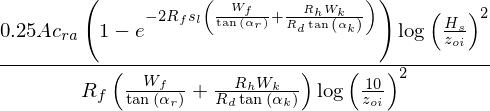

In [96]:
#This cell generates functions from the symbolic expressions so
#that we can make some nice plots. 
#now turning u into a function with the lambdify command...
#sail_form = lambdify(H_s,C_dar)
C_dar

In [70]:
#This cell plots drag components

def plotdrag(H_s,form=False,skin=False):
    #function to plot dependence of drag coefficents on sail height... 2d. Works for both form and skin drag(skin drag kinda)
    assert form or skin, "you need to select either form or skin to plot"
    assert np.logical_xor(form,skin), "you can only plot form or skin... not both."
    D_s_temp = [D_s(i) for i in H_s]
    H_k_temp = [H_k(i) for i in H_s]
    D_k_temp = [D_k(j) for j in D_s_temp]
    #zip stores two arrays ["a","b"] and [1,2] as [["a",1],["b",2]]
    S_zp = zip(H_s,D_s_temp)
    K_zp = zip(H_k_temp,D_k_temp)
    if form:
        totalsail = [C_dar(arr[0],arr[1]) for arr in S_zp]
        totalkeel = [C_dwr(arr[0],arr[1]) for arr in K_zp]
    elif skin:
        totalsail = [C_das(arr[0],arr[1]) for arr in S_zp]
        totalkeel = [C_dws(arr[0],arr[1]) for arr in K_zp]
    totaldrag = np.asarray(totalsail) + np.asarray(totalkeel) 
    fig = plt.figure(dpi=500)
    plt.plot(H_s,totalsail,label="Sails")
    plt.plot(H_s,totalkeel,label="Keels")
    plt.plot(H_s,totaldrag,label="Total")
    plt.legend(loc="center right")
    if form:
        plt.title("How form drag changes with sail height")
    elif skin:
        plt.title("How skin drag changes with sail height")
    plt.xlabel("Height of Sails")
    plt.ylabel("Drag coefficient value")
    plt.xlim([min(H_s),max(H_s)])
    if skin:
        fig.savefig("/home/ben/Desktop/thesis/2D_plot_skin.png")
    elif form:
        fig.savefig("/home/ben/Desktop/thesis/2D_plot_form.png")

#plotdrag(np.linspace(0.3,4.0,50),skin=True)
#plotdrag(np.linspace(0.3,4.0,50),form=True)